# train 1D ML model for more realistic potential at solar radius

In [1]:
import torch
import orbitflows as of
from orbitflows import HamiltonianMappingModel, MWPotential2014_1D, SymplecticCouplingLayer, SimpleNNConditioner, GradientBasedConditioner, H, scaled_H_std, NFWPotential, MiyamotoNagaiPotential
import matplotlib.pyplot as plt
from functools import partial
from astropy import units as u
torch.set_default_dtype(torch.float64)

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['font.size'] = 12.5
plt.rcParams['axes.labelsize'] = 14
plt.rcParams["text.usetex"] = False
plt.rcParams["mathtext.fontset"] = "stix"

In [2]:
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014 as galpy_MW14
from galpy.potential import vcirc, verticalfreq, toVerticalPotential

In [3]:
vertMW14 = toVerticalPotential(galpy_MW14, R=1.0)

In [4]:
ro = 8.0 * u.kpc
vo = 220.0 * u.km / u.s

In [5]:
zlist = torch.linspace(-3.0, 3.0, 100) / ro.value

## Setup model

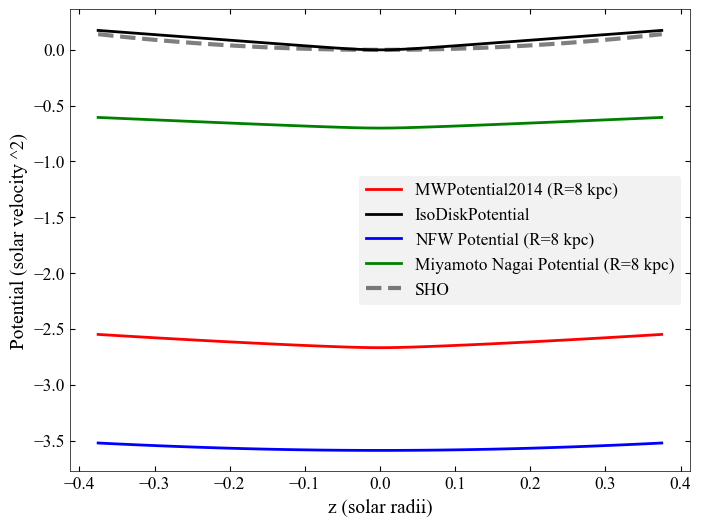

In [6]:
omega = 1 # verticalfreq(galpy_MW14,8 * u.kpc) / (2 * torch.pi)
MW14_1D = MWPotential2014_1D #partial(MWPotential2014, R=1.0)#(zlist/ro.value)
# offset = torch.min(potential_values)
# MW14_1D = lambda z : partial(MWPotential2014, R=1.0)(z) #- offset # define 1D potential

NFW_1D = partial(NFWPotential, R=1.0)#(zlist/ro.value)
# offset_nfw = torch.min(nfw_values)
# NFW_1D = lambda z : partial(NFWPotential, R=1.0)(z) #- offset_nfw

MN_1D = partial(MiyamotoNagaiPotential, R=1.0)#(zlist/ro.value)
# offset_mn = torch.min(mn_values)
# MN_1D = lambda z : partial(MiyamotoNagaiPotential, R=1.0)(z) #- offset_mn


plt.figure(figsize=(8, 6))
plt.plot(zlist, MW14_1D(zlist), c='r', label='MWPotential2014 (R=8 kpc)', lw=2)
plt.plot(zlist, of.isoDiskPotential(zlist), c='k', linestyle='-', lw=2, alpha=1, label='IsoDiskPotential')
plt.plot(zlist, NFW_1D(zlist), c='b', linestyle='-', lw=2, alpha=1, label='NFW Potential (R=8 kpc)')
plt.plot(zlist, MN_1D(zlist), c='green', linestyle='-', lw=2, alpha=1, label='Miyamoto Nagai Potential (R=8 kpc)')
plt.plot(zlist, (omega * zlist)**2, label='SHO', linestyle='--', lw=3, alpha=0.5)
plt.xlabel('z (solar radii)')
plt.ylabel('Potential (solar velocity ^2)')
plt.legend()

In [7]:
# # initialize model
# omega0 = 2 #verticalfreq(galpy_MW14,1.0) #/ (2 * torch.pi)
# model = HamiltonianMappingModel(
#     targetPotential=MW14_1D,
#     omega=omega0,
#     input_dim=2, 
#     num_layers=32,
#     layer_class=SymplecticCouplingLayer,
#     conditioner=GradientBasedConditioner
#     # conditioner_args={
#     #     'num_layers' : 2,
#     #     'projection_dims' : 64,}
#     )
# model.flow = model.flow.double()

In [8]:
from orbitflows import NNConditioner

In [9]:
# # initialize model
# omega0 = 2 #verticalfreq(galpy_MW14,1.0) #/ (2 * torch.pi)
# model = HamiltonianMappingModel(
#     targetPotential=MW14_1D,
#     omega=omega0,
#     input_dim=2, 
#     num_layers=32,
#     layer_class=SymplecticCouplingLayer,
#     conditioner=NNConditioner,
#     conditioner_args={
#         'num_layers' : 2,
#         'projection_dims' : 64,}
#     )
# model.flow = model.flow.double()

In [10]:
# initialize model
omega0 = 1.5 #verticalfreq(galpy_MW14,1.0) #/ (2 * torch.pi)
model = HamiltonianMappingModel(
    targetPotential=MW14_1D,
    omega=omega0,
    input_dim=2, 
    num_layers=4,
    layer_class=SymplecticCouplingLayer,
    conditioner=SimpleNNConditioner,
    conditioner_args={
        'num_layers' : 2,
        'projection_dims' : 64,}
    )
model.flow = model.flow.double()

In [11]:
model.targetPotentialKey

'MWPotential2014_1D'

In [12]:
model.flow.layers[0].conditioner.layers[1]

ReLU()

In [13]:
# for _layer in model.flow.layers:
#     for layer in _layer.conditioner.layers:
#         if isinstance(layer, torch.nn.Linear):
#             torch.nn.init.xavier_uniform_(layer.weight) #xavier_uniform_
#             torch.nn.init.zeros_(layer.bias)
#             print(layer.weight, layer.bias)

In [14]:
model.flow

Flow(
  (layers): ModuleList(
    (0-3): 4 x SymplecticCouplingLayer(
      (conditioner): SimpleNNConditioner(
        (layers): Sequential(
          (0): Linear(in_features=1, out_features=64, bias=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=1, bias=True)
        )
      )
    )
  )
)

In [15]:
model.flow

Flow(
  (layers): ModuleList(
    (0-3): 4 x SymplecticCouplingLayer(
      (conditioner): SimpleNNConditioner(
        (layers): Sequential(
          (0): Linear(in_features=1, out_features=64, bias=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=1, bias=True)
        )
      )
    )
  )
)

## Training Set

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_31130/1157456389.py:16: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729646995093/work/aten/src/ATen/native/TensorShape.cpp:3687.)
  plt.scatter(*training_ps.T, s=5, c='r')



Text(0, 0.5, 'energy')

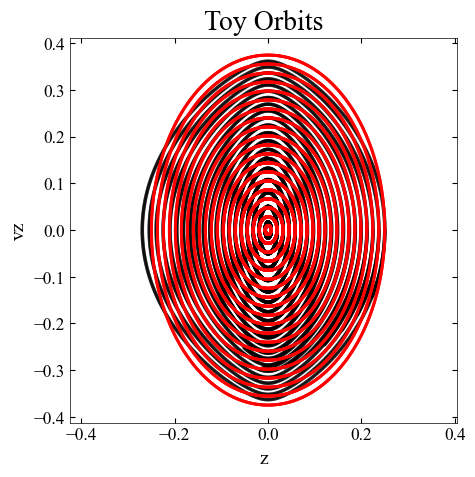

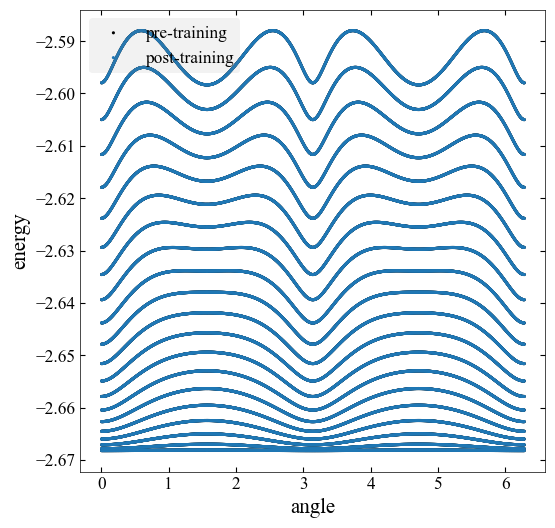

In [16]:
from galpy.potential import verticalfreq
import numpy as np

n_actions = 20
n_angles = 1000
training_ps, training_aa = of.generate_sho_orbits(num_orbits=n_actions, omega=omega0, t_end = 2*torch.pi / omega0, n_steps=n_angles, r_bounds=torch.tensor([0.05, 2])/ro.value)
training_aa = training_aa.to(torch.float64)

galpy_orbits = Orbit([[1.0, 0.0, 1.0, z_i ,0.0, 0.0] for z_i in training_ps[...,0][...,0]])#[R,vR,vT(,z,vz,phi)]
tlist = np.linspace(0, 2*verticalfreq(galpy_MW14, 1.0), 1000)
galpy_orbits.integrate(t=tlist, pot=galpy_MW14)


plt.figure(figsize=(5, 5))
plt.scatter(galpy_orbits.z(tlist), galpy_orbits.vz(tlist), c='k', s=7, alpha=0.5)
plt.scatter(*training_ps.T, s=5, c='r')

plt.axis('equal')
plt.xlabel('z')
plt.ylabel('vz')
plt.title('Toy Orbits', fontsize=20)

plt.figure(figsize=(6, 6))
plt.scatter(training_aa[...,0], H(training_ps, model.targetPotential).detach(), s=5, label='pre-training')
plt.scatter(training_aa[...,0], model.hamiltonian(training_aa).detach(), s=5, label='post-training')
plt.legend()
plt.xlabel('angle', fontsize=15)
plt.ylabel('energy', fontsize=15)

In [17]:
def smoothing_term(ps, targetPotential):
    '''loss term that enforces smoothness by quantifying how much nearby points differ'''
    return torch.diff(H(ps, targetPotential), dim=-1).abs().std() + torch.diff(H(ps, targetPotential), dim=-1).abs().mean() 

def smooth_flat_H(ps, targetPotential, smoothing_term=smoothing_term, smoothing_amp=0.1):
    '''loss term that enforces smoothness by quantifying how much nearby points differ'''
    return (scaled_H_std(ps, targetPotential) + smoothing_amp * smoothing_term(ps, targetPotential))

In [18]:
torch.autograd.set_detect_anomaly(True)

100%|██████████| 1000/1000 [00:38<00:00, 26.07it/s]


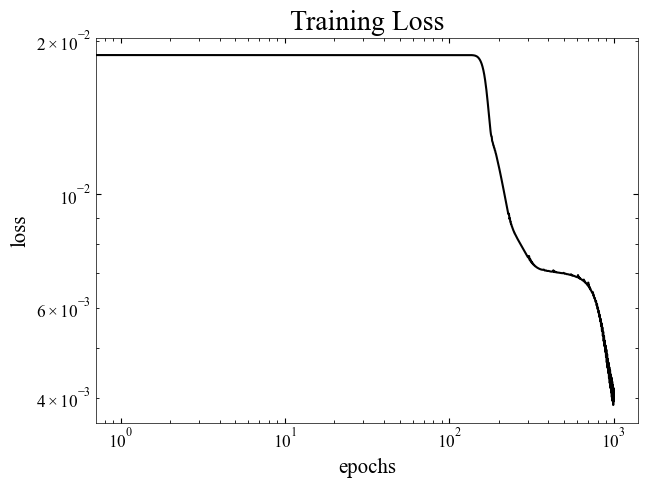

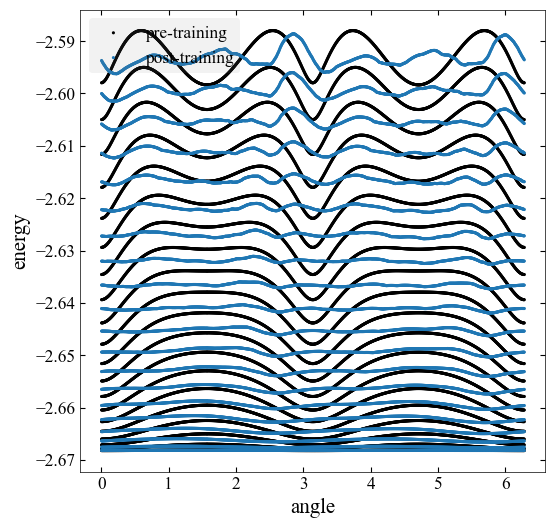

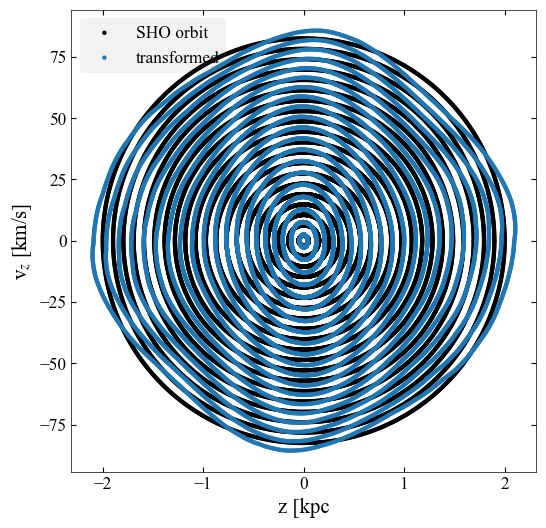

In [19]:
# train model
steps = 1000
model.train(training_ps, steps, lr=1e-3)
# model.train(training_ps, steps, lr=1e-4)#, loss_function=smooth_flat_H, lf_args={'targetPotential': model.targetPotential, 'smoothing_amp':1.5e3})
# model.train(training_ps, steps, lr=1e-5)

# plot loss
plt.figure(figsize=(7, 5))
plt.loglog(model.loss_list)
plt.xlabel('epochs', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.title('Training Loss', fontsize=20)
plt.show()

# # plot performance for one orbit
# plt.figure(figsize=(8, 5))
# plt.plot(aa_guess[0][...,0].detach(), model.hamiltonian(aa_guess[0]).detach())
# plt.plot(aa_guess[0][...,0].detach(), np.repeat(model.hamiltonian(aa_guess[0]).mean().detach(), len(aa_guess[0][...,0].detach())), 'r--')
# plt.xlabel('time', fontsize=15)
# plt.ylabel('energy', fontsize=15)
# plt.title('model performance', fontsize=20)
# plt.show()
plt.figure(figsize=(6, 6))
plt.scatter(training_aa[...,0], H(training_ps, model.targetPotential).detach(), s=5, label='pre-training')
plt.scatter(training_aa[...,0], model.hamiltonian(training_aa).detach(), s=5, label='post-training')
plt.legend()
plt.xlabel('angle', fontsize=15)
plt.ylabel('energy', fontsize=15)
plt.show()

# plot energy for transformed orbits (with NF) and without (pre-training)
plt.figure(figsize=(6,6))
plt.scatter(training_ps.T[0] * ro, training_ps.T[1] * vo, s=10, label='SHO orbit')
plt.scatter(model.flow(training_ps).T.detach()[0]*ro, model.flow(training_ps).T.detach()[1]*vo, s=10, label='transformed')
plt.xlabel('z [kpc', fontsize=15)
plt.ylabel('v$_z$ [km/s]', fontsize=15)
plt.legend()
plt.show()

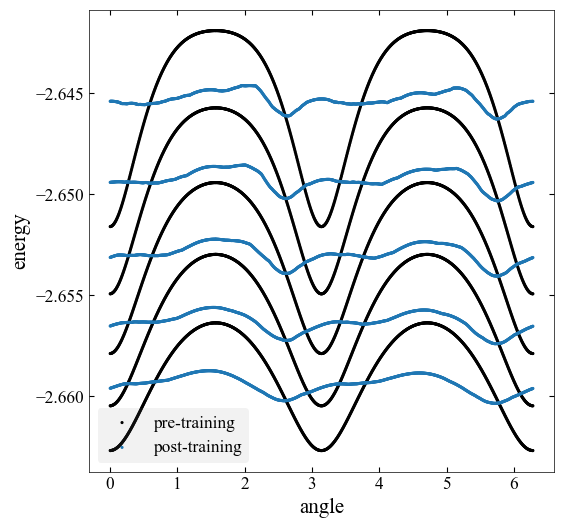

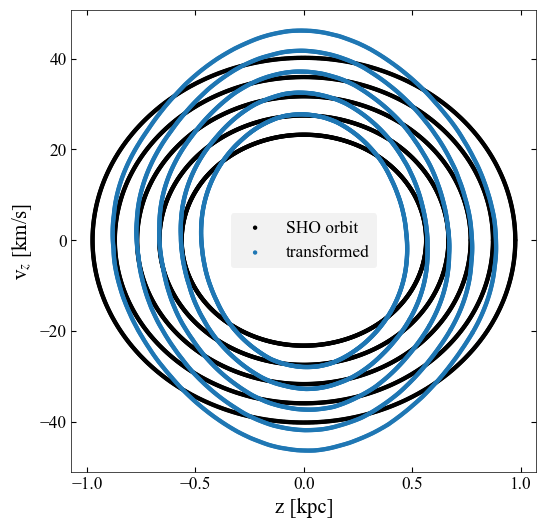

In [20]:
plt.figure(figsize=(6, 6))
plt.scatter(training_aa[...,0][5:10], H(training_ps, model.targetPotential).detach()[5:10], s=5, label='pre-training')
plt.scatter(training_aa[...,0][5:10], model.hamiltonian(training_aa).detach()[5:10], s=5, label='post-training')
plt.legend()
plt.xlabel('angle', fontsize=15)
plt.ylabel('energy', fontsize=15)
plt.show()

# plot energy for transformed orbits (with NF) and without (pre-training)
plt.figure(figsize=(6,6))
plt.scatter(training_ps.T[0][:,5:10] * ro, training_ps.T[1][:,5:10] * vo, s=10, label='SHO orbit')
plt.scatter(model.flow(training_ps).T.detach()[0][:,5:10]*ro, model.flow(training_ps).T.detach()[1][:,5:10]*vo, s=10, label='transformed')
plt.xlabel('z [kpc]', fontsize=15)
plt.ylabel('v$_z$ [km/s]', fontsize=15)
plt.legend()
plt.show()

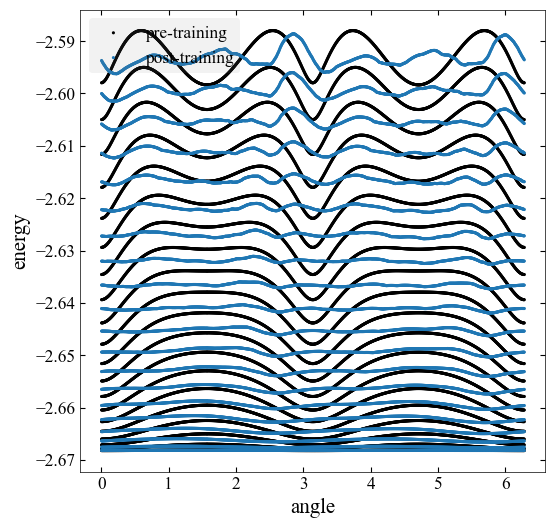

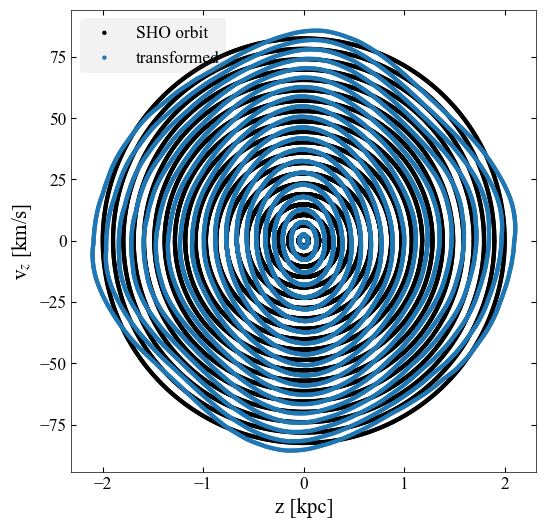

In [21]:
plt.figure(figsize=(6, 6))
plt.scatter(training_aa[...,0], H(training_ps, model.targetPotential).detach(), s=5, label='pre-training')
plt.scatter(training_aa[...,0], model.hamiltonian(training_aa).detach(), s=5, label='post-training')
plt.legend()
plt.xlabel('angle', fontsize=15)
plt.ylabel('energy', fontsize=15)
plt.show()

# plot energy for transformed orbits (with NF) and without (pre-training)
plt.figure(figsize=(6,6))
plt.scatter(training_ps.T[0] * ro, training_ps.T[1] * vo, s=10, label='SHO orbit')
plt.scatter(model.flow(training_ps).T.detach()[0]*ro, model.flow(training_ps).T.detach()[1]*vo, s=10, label='transformed')
plt.xlabel('z [kpc]', fontsize=15)
plt.ylabel('v$_z$ [km/s]', fontsize=15)
plt.legend()
plt.show()

In [22]:
model.save('test/test_model')

In [23]:
loaded_model = of.HamiltonianMappingModel.load('test/test_model')

/Users/gabrielpfaffman/Repos/orbitflows/orbitflows/model/HamiltonianMappingModel.py:136: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  instance.flow.load_state_dict(torch.lo

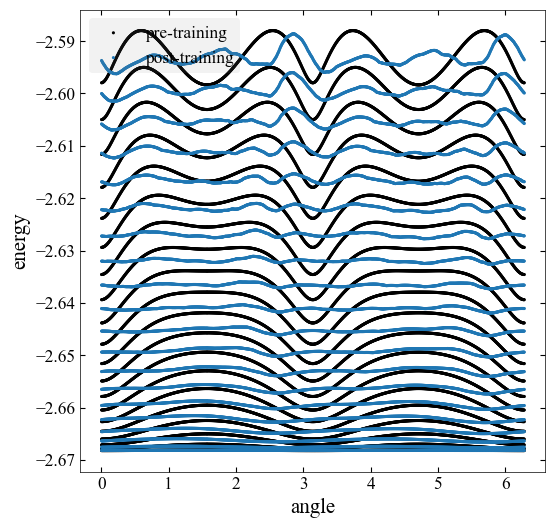

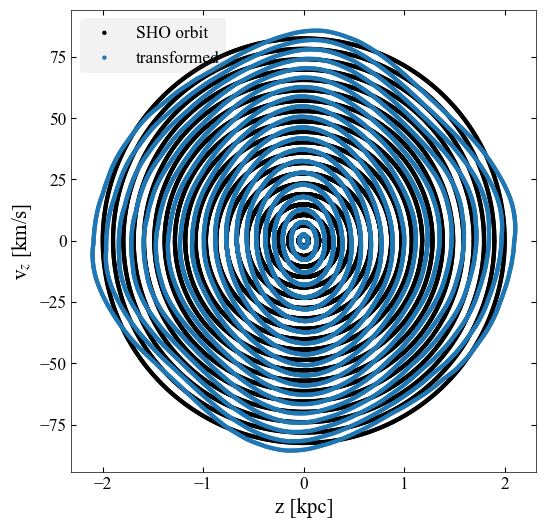

In [24]:
plt.figure(figsize=(6, 6))
plt.scatter(training_aa[...,0], H(training_ps, loaded_model.targetPotential).detach(), s=5, label='pre-training')
plt.scatter(training_aa[...,0], loaded_model.hamiltonian(training_aa).detach(), s=5, label='post-training')
plt.legend()
plt.xlabel('angle', fontsize=15)
plt.ylabel('energy', fontsize=15)
plt.show()

# plot energy for transformed orbits (with NF) and without (pre-training)
plt.figure(figsize=(6,6))
plt.scatter(training_ps.T[0] * ro, training_ps.T[1] * vo, s=10, label='SHO orbit')
plt.scatter(loaded_model.flow(training_ps).T.detach()[0]*ro, loaded_model.flow(training_ps).T.detach()[1]*vo, s=10, label='transformed')
plt.xlabel('z [kpc]', fontsize=15)
plt.ylabel('v$_z$ [km/s]', fontsize=15)
plt.legend()
plt.show()

In [33]:
loaded_model.targetPotential.func.__name__

'MWPotential2014_1D'

In [43]:
copy_dict = model.potential_kwargs
for key, value in copy_dict.items():
    copy_dict[key] = torch.tensor(value)

In [44]:
copy_dict

{'R': tensor(1.), 'amp': tensor(1.)}

In [31]:
from orbitflows import generate_orbits_aa

In [500]:
# z0s = torch.linspace(0.5, 1.5, 10)
# ic_ps = torch.stack((z0s, torch.zeros_like(z0s))).T
# ic_aa = model.ps_to_aa(ic_ps)
# orbit_aa_ex = torch.zeros(10, 1000, 2)
# orbit_aa_ex[...,1] = torch.linspace(0, 2 * np.pi, 1000) 
# orbit_aa_ex[...,0] = ic_aa[...,1].repeat(1000,1).T
# orbit_ps_ex = model.aa_to_ps(orbit_aa_ex)

In [501]:
n_orbits = 10
_, ex_aa = of.generate_sho_orbits(num_orbits=n_orbits, omega=omega0, t_end = 2*torch.pi / omega0, n_steps=n_angles, r_bounds=torch.tensor([0.5, 1.5])/ro.value)

In [502]:
ex_NF_ps = model.aa_to_ps(ex_aa.to(torch.float64))

In [503]:
integrated_orbit_ex = Orbit(ex_NF_ps[:,0].detach().numpy())
ts= np.linspace(0,10,1000)
integrated_orbit_ex.integrate(t=ts, pot=vertMW14)

### AA --> PS

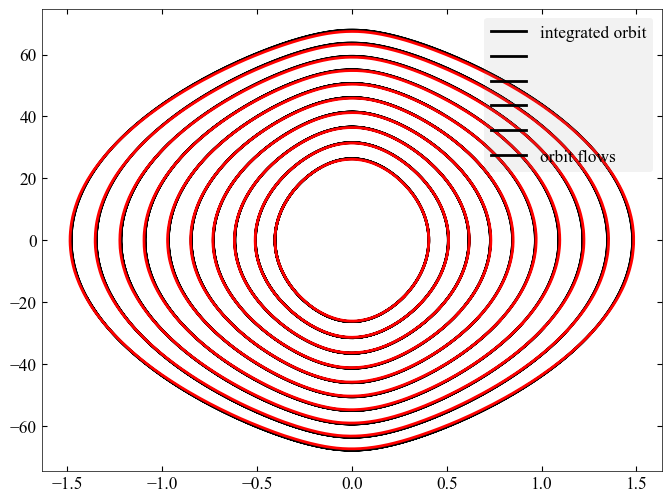

In [504]:

plt.plot(integrated_orbit_ex.x(ts).T*ro, integrated_orbit_ex.vx(ts).T*vo, c='k', lw=2)
plt.plot(ex_NF_ps[...,0].detach().T * ro, ex_NF_ps[...,1].detach().T * vo, c='r', lw=2)
plt.legend(labels=['integrated orbit', None, None, None,None, 'orbit flows'])


In [491]:
def percent_error(value):
    return np.log10((value - value[0]) /np.mean(value))

<>:9: SyntaxWarning: invalid escape sequence '\l'

<>:9: SyntaxWarning: invalid escape sequence '\l'

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_12747/818584098.py:9: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\log_{10}(\Delta E / \langle E \\rangle)$', fontsize=20)

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_12747/818584098.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues = cm.get_cmap('Blues', n_orbits+5)

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_12747/818584098.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  grays = cm.get_cmap('Greys', n_orbits+5)

/var/f

Text(0, 0.5, '$\\log_{10}(\\Delta E / \\langle E \\rangle)$')

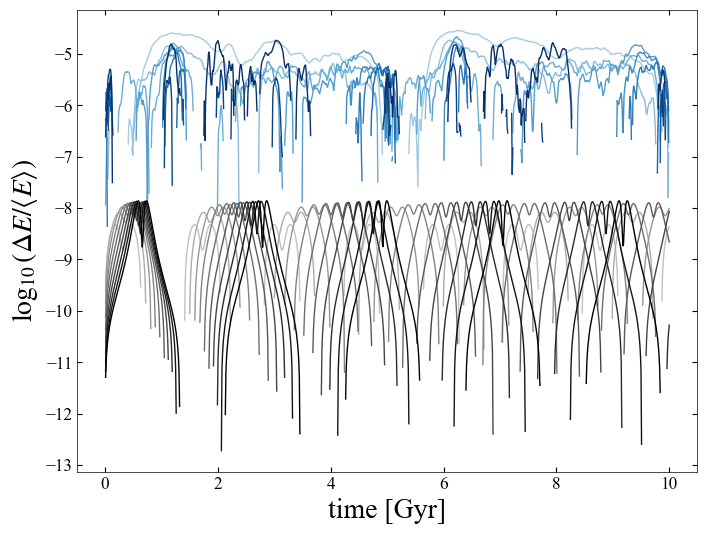

In [512]:
blues = cm.get_cmap('Blues', n_orbits+5)
grays = cm.get_cmap('Greys', n_orbits+5)
for i in range(n_orbits):
    plt.plot(ts, percent_error(integrated_orbit_ex.E(ts)[i]), c=grays(i+5), lw=1)
    plt.plot(ts, percent_error(H(ex_NF_ps, model.targetPotential).detach().numpy()[i]), c=blues(i+5), lw=1)
# plt.plot(percent_error(integrated_orbit_ex.E(ts)), c='k', lw=1)
# plt.plot(percent_error(H(ex_NF_ps, model.targetPotential).detach().numpy()), c=cm.get_cmap('Blues', n_orbits), lw=1)
plt.xlabel('time [Gyr]', fontsize=20)
plt.ylabel('$\log_{10}(\Delta E / \langle E \\rangle)$', fontsize=20)

# Compare with Adiabatic Approximation

In [410]:
from galpy.actionAngle import actionAngleVertical
aAV= actionAngleVertical(pot=vertMW14, c=True)

In [448]:
n_orbits = 10
zs = np.linspace(0.04, 1.0, n_orbits)/ro.value
ps_ic = np.zeros((len(zs), 2))
ps_ic[:,0] = zs

In [449]:
integrated_orbit_ex = Orbit(ps_ic)
ts= np.linspace(0,10,1000)
integrated_orbit_ex.integrate(t=ts, pot=vertMW14)

In [ ]:
ex_NF_ps = model.aa_to_ps(ex_aa.to(torch.float64))

In [450]:
numer_js = np.zeros((n_orbits, n_angles))
for i in range(n_orbits):
    numer_js[i] = aAV(integrated_orbit_ex.x(ts)[i], integrated_orbit_ex.vx(ts)[i])

In [454]:
ic = torch.tensor([integrated_orbit_ex.x(ts), integrated_orbit_ex.vx(ts)]).requires_grad_(True)

In [455]:
nf_js = model.ps_to_aa(ic.T)[...,-1].T

Text(0, 0.5, '$J_z$')

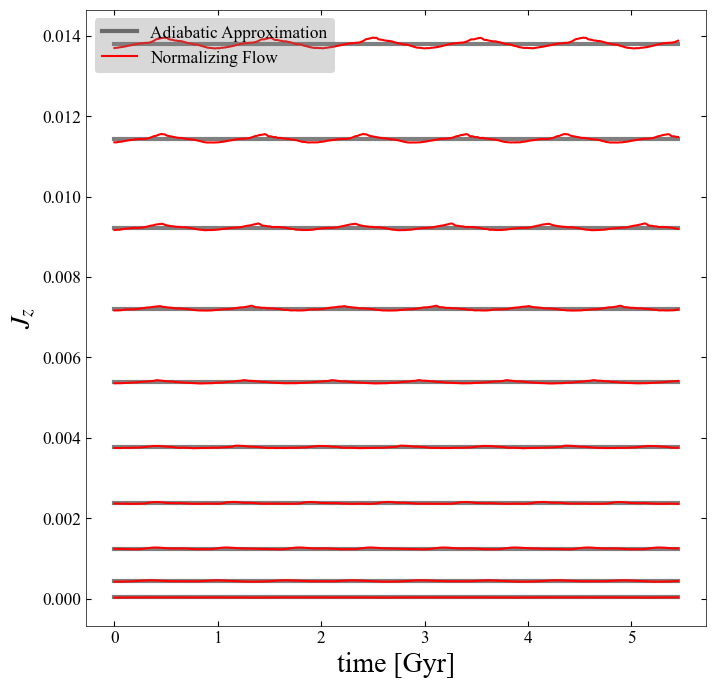

In [513]:
plt.figure(figsize=(8, 8))  
plt.plot(tlist, numer_js.T[:, 1:], c='k', lw=3, alpha=0.5)
plt.plot(tlist, numer_js.T[:, 0], c='k', lw=3, alpha=0.5, label='Adiabatic Approximation')

plt.plot(tlist, nf_js.T.detach()[:,1:], c='r')
plt.plot(tlist, nf_js.T.detach()[:,0], c='r', label='Normalizing Flow')
#plt.plot(tlist, tlist, c='r')

plt.legend(framealpha=0.3, loc='upper left')
plt.xlabel('time [Gyr]', fontsize=20)
plt.ylabel('$J_z$', fontsize=20)

<>:16: SyntaxWarning: invalid escape sequence '\l'

<>:16: SyntaxWarning: invalid escape sequence '\l'

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_12747/471435665.py:16: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\log_{10}(\Delta J_z / \langle J_z \\rangle)$', fontsize=20)



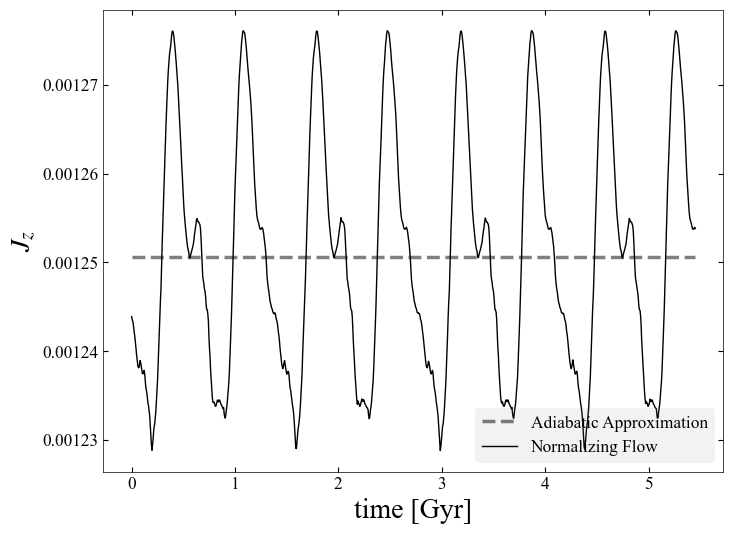

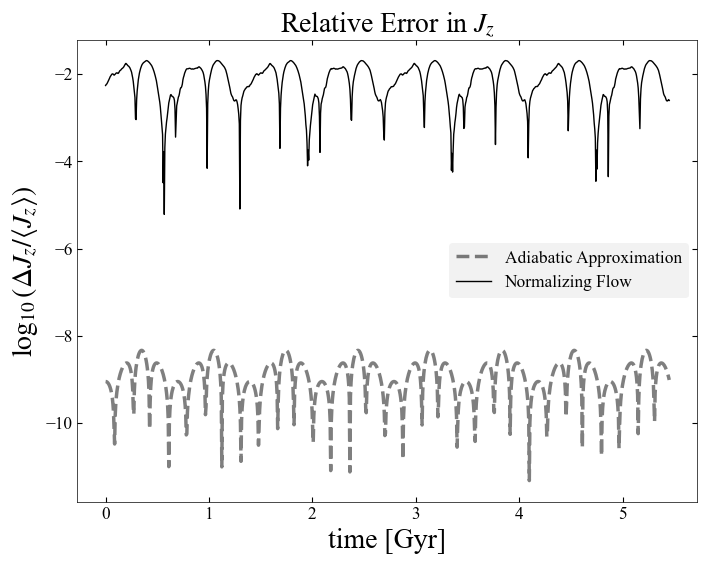

In [514]:
i = 2

plt.figure(figsize=(8, 6))
plt.plot(tlist, numer_js.T[:, i], label='Adiabatic Approximation',  c='k', linestyle='--', alpha=0.5, lw=2.5,)
plt.plot(tlist, nf_js.T.detach()[:,i],label='Normalizing Flow', c='k', lw=1.)
plt.legend()
plt.xlabel('time [Gyr]', fontsize=20)
plt.ylabel('$J_z$', fontsize=20)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(tlist, np.log10(np.abs((numer_js[i].T-np.mean(numer_js[i], axis=0))/np.mean(numer_js[i], axis=0))), c='k', linestyle='--', alpha=0.5, lw=2.5, label='Adiabatic Approximation')
plt.plot(tlist, torch.log10(torch.abs((nf_js[i].T-torch.mean(nf_js[i], axis=0))/torch.mean(nf_js[i], axis=0))).detach(), c='k', lw=1., label='Normalizing Flow')
plt.legend()
plt.xlabel('time [Gyr]', fontsize=20)
plt.ylabel('$\log_{10}(\Delta J_z / \langle J_z \\rangle)$', fontsize=20)
plt.title('Relative Error in $J_z$', fontsize=20)
plt.show()

In [498]:
H(ex_NF_ps, model.targetPotential).detach().numpy()

array([[-2.66112651, -2.66112576, -2.66112515, ..., -2.66112726,
        -2.66112691, -2.66112651],
       [-2.65359279, -2.65359282, -2.65359336, ..., -2.65359476,
        -2.6535933 , -2.65359279],
       [-2.64428169, -2.6442826 , -2.64428105, ..., -2.64428401,
        -2.64428153, -2.64428169],
       [-2.63344125, -2.6334402 , -2.63344107, ..., -2.63344226,
        -2.63344184, -2.63344125],
       [-2.62122575, -2.62122535, -2.62122708, ..., -2.62122407,
        -2.6212257 , -2.62122575]], shape=(5, 1000))

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_12747/3933934378.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = ListedColormap(cm.get_cmap('Dark2')(np.linspace(0, 0.25, n_actions//3)))

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_12747/3933934378.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels([f'{i:.3f}' for i in jrs.T[0][::3]])



Text(0, 0.5, 'log$_{10}$ (J$_z$ / mean(J$_z$)))')

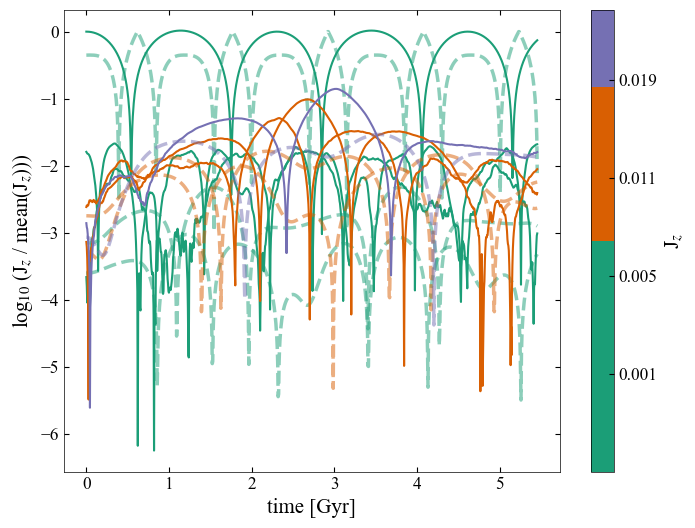

In [267]:
#plt.plot(tlist, np.log10(np.fabs((jrs.T-np.mean(jrs, axis=1))/np.mean(jrs, axis=1))))

import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
cmap = ListedColormap(cm.get_cmap('Dark2')(np.linspace(0, 0.25, n_actions//3)))
for i in range(n_actions//3):
    plt.plot(tlist, np.log10(np.abs((jrs[i*3].T-np.mean(jrs[i*3], axis=0))/np.mean(jrs[i*3], axis=0))), c=cmap(i), linestyle='--', alpha=0.5, lw=2.5)
    plt.plot(tlist, torch.log10(torch.abs((nf_jrs[i*3].T-torch.mean(nf_jrs[i*3], axis=0))/torch.mean(nf_jrs[i*3], axis=0))).detach(), c=cmap(i), lw=1.5)

# Add a discrete colorbar
ax = plt.gca() # Get current axes
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=jrs.T[0].min(), vmax=jrs.T[0].max()))
sm._A = []  # Hack to fix a bug in ScalarMappable
cbar = plt.colorbar(sm, ax=ax)
#cbar.set_ticks(jrs.T[0][::3])
cbar.set_ticklabels([f'{i:.3f}' for i in jrs.T[0][::3]])
cbar.set_label('J$_z$', fontsize=15)
plt.xlabel('time [Gyr]', fontsize=15)
plt.ylabel('log$_{10}$ (J$_z$ / mean(J$_z$)))', fontsize=15)

In [513]:
model.ps_to_aa()

TypeError: HamiltonianMappingModel.ps_to_aa() missing 1 required positional argument: 'ps'

Note! The parameter space you initilize might not be the parameter space you end up exploring

In [104]:
model.targetPotential

functools.partial(<function MWPotential2014 at 0x171bb3ba0>, R=1.0)

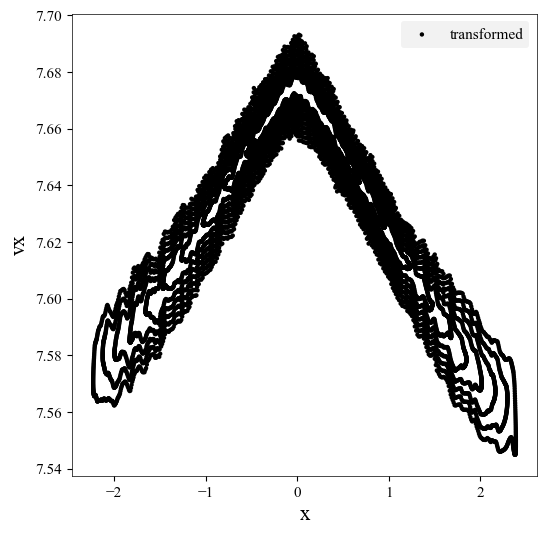

In [105]:
# plot energy for transformed orbits (with NF) and without (pre-training)
plt.figure(figsize=(6,6))
#plt.scatter(*training_ps.T, s=10, label='SHO orbit')
plt.scatter(*model.flow(training_ps).T.detach(), s=10, label='transformed')
plt.xlabel('x', fontsize=15)
plt.ylabel('vx', fontsize=15)
plt.legend()
plt.show()

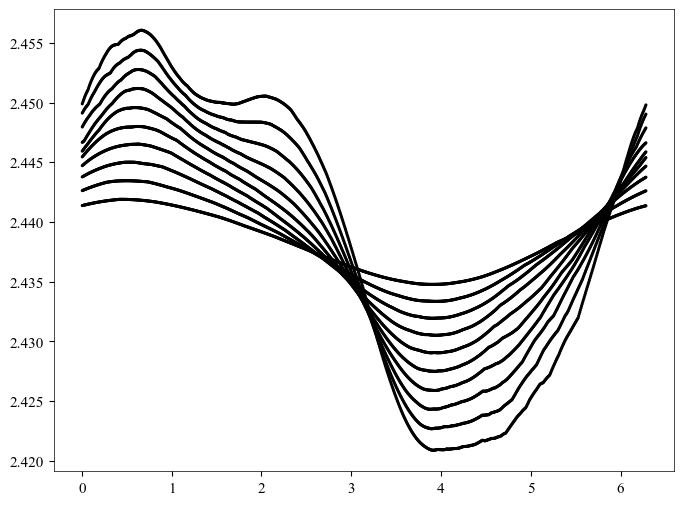

In [36]:
plt.scatter(training_aa[...,0], model.hamiltonian(training_aa).detach(), s=5, label='post-training')